In [34]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Import estimators and transformers
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from src.features import CustomEncoder, ColumnSelector
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor

# Import predictors
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

# Import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext autoreload
%autoreload 2

path_processed = '/home/matteo@COPPET/Documents/data_science/projects/housing_prices_firenze/data/processed/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv(path_processed+'data_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8714 entries, 0 to 8713
Data columns (total 57 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Tipologia                                  8714 non-null   object 
 1   Tipo_proprietà                             8277 non-null   object 
 2   Zona                                       8714 non-null   object 
 3   Anno_costruzione                           6334 non-null   float64
 4   Stato                                      8483 non-null   object 
 5   Prezzo_EUR                                 8714 non-null   float64
 6   Superficie_m2                              8714 non-null   float64
 7   Prezzo_per_m2                              8714 non-null   float64
 8   Riscaldamento_A_C                          8714 non-null   object 
 9   Tipo_riscaldamento                         6760 non-null   object 
 10  Alimentazione_riscaldame

In [ ]:
# predict log(Price) - DONE: improves things a little
# MAE vs. RMSE? - DONE: note sure if it's any better
# plot true vs. pred values; - DONE: useful to see
# imputing with sophisticated algo but choosing the right features - NOT SURE THIS IS WORTH IT
# fit a LR with 2-3 features and use as benchmark if good result (m2, classe energetica) - DONE: helped me find out that there are garbage features
# classe energetica distributions seem similar ==> use to impute construction year - NOT SURE THIS IS WORTH IT

### Removing nans

In [ ]:
#df = df.drop(columns=['Alimentazione_riscaldamento', 'Tipo_riscaldamento']).dropna(how='any')

### 1. Selecting features and splitting data

In [9]:
features = df.columns[:19]
target = 'Prezzo_EUR'
drop_cols = ['Prezzo_per_m2'] + [target]

X = df[features].drop(columns=drop_cols)
y = np.log1p(df[target].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Index(['Tipologia', 'Tipo_proprietà', 'Zona', 'Anno_costruzione', 'Stato',
       'Superficie_m2', 'Riscaldamento_A_C', 'Tipo_riscaldamento',
       'Alimentazione_riscaldamento', 'Classe_energetica', 'Ascensore',
       'Accesso_disabili', 'Piano', 'Posti_garage', 'Posti_esterni',
       'Num_bagni', 'Num_tot_locali'],
      dtype='object')


### 2. Pre-processing pipelines

In [10]:
cat_features = X.select_dtypes(include='object').columns
num_features = X.select_dtypes(exclude='object').columns

cat_transformer = Pipeline([
    ('imputing', SimpleImputer(strategy='most_frequent')),
    ('oh_encoding', OneHotEncoder(handle_unknown='ignore'))
])

num_transformer = Pipeline([
    ('transforming', PowerTransformer()),
    ('imputing', SimpleImputer(strategy='median'))
])

preprocessing_pipeline = ColumnTransformer([
    ('categoricals', cat_transformer, cat_features),
    ('numericals', num_transformer, num_features)
],
    remainder='passthrough'
)

### 3. Modeling

#### 3.1 Folds, metrics and plotting results

In [26]:
# Folds and metrics
num_folds = 5
kf = KFold(num_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
scoring = "neg_mean_squared_error"

In [7]:
def plot_predictions(pred_values, cv_values, true_values):
    fig, ax = plt.subplots(figsize=(16, 8))

    ax1 = plt.subplot(1, 2, 1)
    ax1.scatter(true_values, pred_values, edgecolors=(0, 0, 0))
    ax1.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'k--', lw=4)
    ax1.set_xlabel('Measured')
    ax1.set_ylabel('Predicted')
    ax1.set_title('Training set results')

    ax2 = plt.subplot(1, 2, 2)
    ax2.scatter(true_values, cv_values, edgecolors=(0, 0, 0))
    ax2.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'k--', lw=4)
    ax2.set_xlabel('Measured')
    ax2.set_ylabel('Predicted')
    ax2.set_title('Cross-validation results')
    return fig

#### 3.2 First model (benchmarking)

In [13]:
pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', LinearRegression())
])

pipe.fit(X_train, y_train)
train_preds = pipe.predict(X_train)

# Train set score
print('Training RSME: {}'.format(np.sqrt(mean_squared_error(y_train, train_preds))))

# Cross-validation score
scores = np.sqrt(-cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=kf))
print('Mean cross-validation RMSE: {}'.format(np.mean(scores)))

# Cross-validation predictions
cv_preds = cross_val_predict(pipe, X_train, y_train, cv=kf)

Training RSME: 0.21620082954471478
Mean cross validation RMSE: 0.2197074427595631


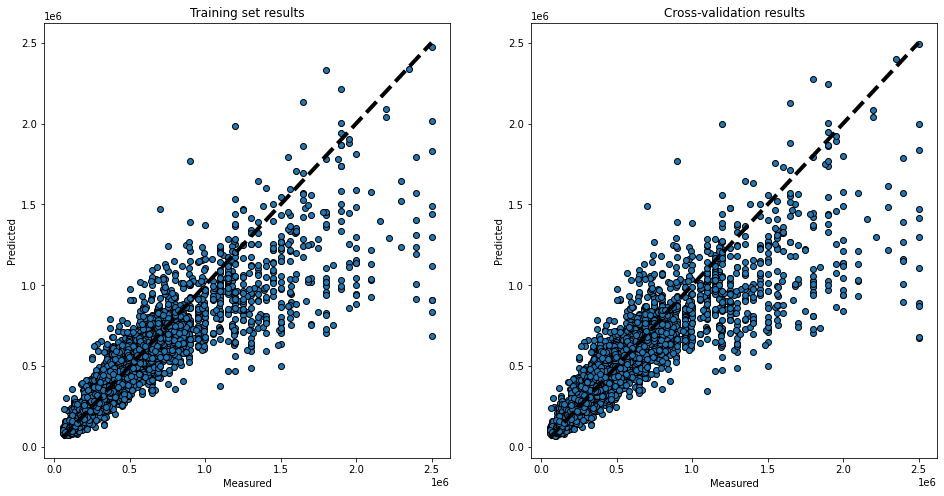

In [14]:
# Plot predicted vs. true values
exp_train = np.expm1(train_preds)
exp_cv = np.expm1(cv_preds)
exp_y = np.expm1(y_train)

pred_plot = plot_predictions(exp_train, exp_cv, exp_y)
plt.show()

Our baseline linear regression model shows the same RMSE for training and test set which is a sign of high bias, as expected. We will try to improve this by using more complex models.

#### 3.3 Other models

In [15]:
# Define algorithms
models = []
models.append(('RID', Ridge()))
models.append(('SVR', SVR()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('RDMF', RandomForestRegressor(random_state=0)))
models.append(('EXTR', ExtraTreesRegressor(random_state=0)))
models.append(('GBOO', GradientBoostingRegressor(random_state=0)))
models.append(('ADA', AdaBoostRegressor(random_state=0)))

train_results = []
cv_results = []
names = []
for name, model in models:
    
    # Define pipeline
    pipe = Pipeline([
        ('preprocessing', preprocessing_pipeline),
        ('model', model)
    ])
    
    # Train score
    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_train)
    train_error = np.sqrt(mean_squared_error(y_train, train_preds))
    train_results.append(train_error)

    # CV score
    cv_error = np.sqrt(-cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=kf))
    cv_results.append(cv_error)
    names.append(name)
    msg = "%s: %f (%f)" %(name, np.mean(cv_results), np.std(cv_results))
    print(msg)

RID: 0.219503 (0.010187)
SVR: 0.211544 (0.012802)
CART: 0.235699 (0.036374)
RDMF: 0.228838 (0.034279)
EXTR: 0.224869 (0.032096)
GBOO: 0.223055 (0.029909)
ADA: 0.231770 (0.035276)


The results are much better when removing outliers from the data!

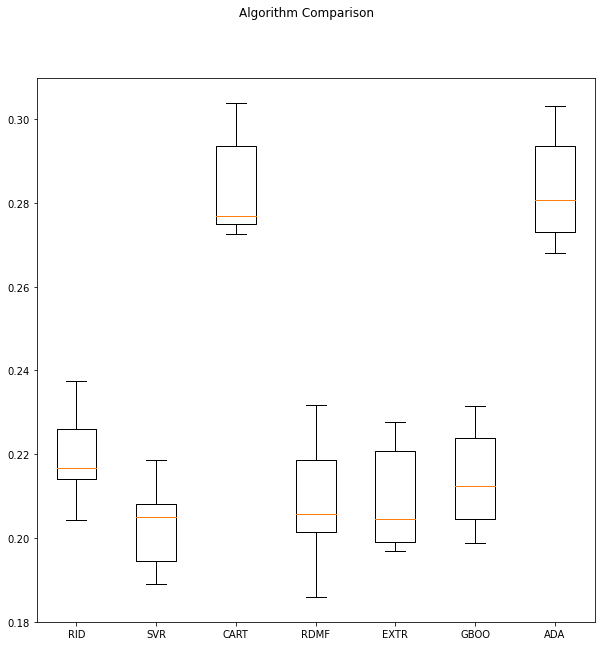

In [17]:
# Compare Algorithms
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(cv_results)
ax.set_xticklabels(names)
plt.show()

The support vector regressor seems to yield the best results out of all of the models. We'll do some tuning on that model next!

### 4. Hyperparameter tuning

In [38]:
pipe = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', SVR())
])

param_grid = {
    'model__C': 10. ** np.arange(-3, 3),
    'model__gamma': 10. ** np.arange(-3, 3),
}

grid_search = GridSearchCV(pipe, param_grid, scoring=scoring, cv=kf)
grid_search.fit(X_train, y_train)

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

0.326239333894144 {'model__C': 0.001, 'model__gamma': 0.001}
0.23184297035576434 {'model__C': 0.001, 'model__gamma': 0.01}
0.2398952098572739 {'model__C': 0.001, 'model__gamma': 0.1}
0.345006613255858 {'model__C': 0.001, 'model__gamma': 1.0}
0.3455668251181166 {'model__C': 0.001, 'model__gamma': 10.0}
0.34559899377287745 {'model__C': 0.001, 'model__gamma': 100.0}
0.20651359996761118 {'model__C': 0.01, 'model__gamma': 0.001}
0.08869347537234847 {'model__C': 0.01, 'model__gamma': 0.01}
0.1104326441273699 {'model__C': 0.01, 'model__gamma': 0.1}
0.339942751815997 {'model__C': 0.01, 'model__gamma': 1.0}
0.3446855516738422 {'model__C': 0.01, 'model__gamma': 10.0}
0.3450090730413891 {'model__C': 0.01, 'model__gamma': 100.0}
0.08212314952655156 {'model__C': 0.1, 'model__gamma': 0.001}
0.05242678374944036 {'model__C': 0.1, 'model__gamma': 0.01}
0.05306786746890359 {'model__C': 0.1, 'model__gamma': 0.1}
0.3099378082459624 {'model__C': 0.1, 'model__gamma': 1.0}
0.3386391524182545 {'model__C': 0.1

In [43]:
np.sqrt(-grid_search.best_score_)

0.20462276738312754

In [41]:
pipe = grid_search.best_estimator_

pipe.fit(X_train, y_train)
train_preds = pipe.predict(X_train)

# Train set score
print('Training RSME: {}'.format(np.sqrt(mean_squared_error(y_train, train_preds))))

# Cross-validation score
scores = np.sqrt(-cross_val_score(pipe, X_train, y_train, scoring=scoring, cv=kf))
print('Mean cross-validation RMSE: {}'.format(np.mean(scores)))

# Cross-validation predictions
cv_preds = cross_val_predict(pipe, X_train, y_train, cv=kf)

Training RSME: 0.17871864146264113
Mean cross validation RMSE: 0.20449208484628595


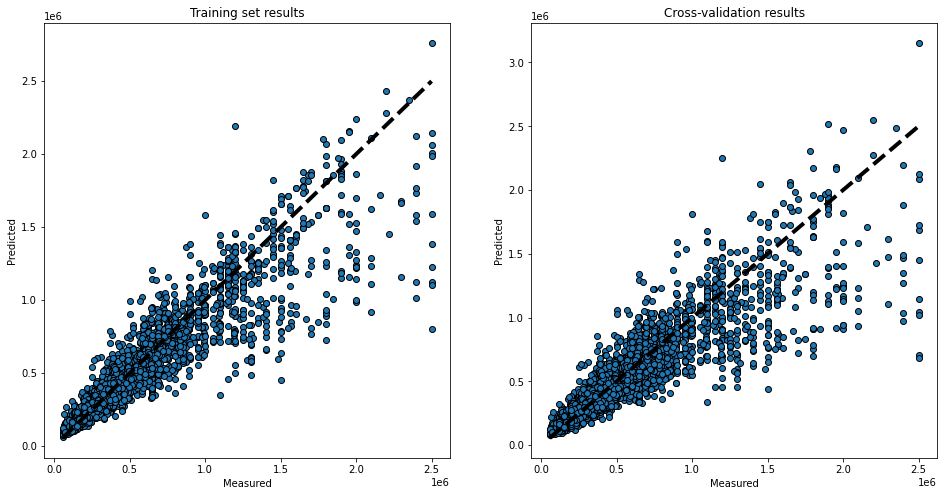

In [42]:
# Plot predicted vs. true values
exp_train = np.expm1(train_preds)
exp_cv = np.expm1(cv_preds)
exp_y = np.expm1(y_train)

pred_plot = plot_predictions(exp_train, exp_cv, exp_y)
plt.show()